# 0. Install packages

In [ ]:
%pip install numpy pandas matplotlib seaborn scikit-learn

# 1. Imports and Constants

In [1]:
import pandas as pd
import kagglehub

RANDOM_STATE = 42

# 2. Dataset loading and inspection

## 2.0 Load Dataset

In [2]:
from kagglehub import KaggleDatasetAdapter
original_df = kagglehub.dataset_load(
  KaggleDatasetAdapter.PANDAS,
  "joebeachcapital/differentiated-thyroid-cancer-recurrence",
  "Thyroid_Diff.csv",
)

## 2.1 DataFrame Overview

### 2.1.0 Shape

In [3]:
original_df.shape

(383, 17)

### 2.1.1 Columns

In [4]:

original_df.columns

Index(['Age', 'Gender', 'Smoking', 'Hx Smoking', 'Hx Radiothreapy',
       'Thyroid Function', 'Physical Examination', 'Adenopathy', 'Pathology',
       'Focality', 'Risk', 'T', 'N', 'M', 'Stage', 'Response', 'Recurred'],
      dtype='object')

### 2.1.2 First 5 rows (head)

In [5]:
original_df.head()

,Age,Gender,Smoking,Hx Smoking,Hx Radiothreapy,Thyroid Function,Physical Examination,Adenopathy,Pathology,Focality,Risk,T,N,M,Stage,Response,Recurred
0,27,F,No,No,No,Euthyroid,Single nodular goiter-left,No,Micropapillary,Uni-Focal,Low,T1a,N0,M0,I,Indeterminate,No
1,34,F,No,Yes,No,Euthyroid,Multinodular goiter,No,Micropapillary,Uni-Focal,Low,T1a,N0,M0,I,Excellent,No
2,30,F,No,No,No,Euthyroid,Single nodular goiter-right,No,Micropapillary,Uni-Focal,Low,T1a,N0,M0,I,Excellent,No
3,62,F,No,No,No,Euthyroid,Single nodular goiter-right,No,Micropapillary,Uni-Focal,Low,T1a,N0,M0,I,Excellent,No
4,62,F,No,No,No,Euthyroid,Multinodular goiter,No,Micropapillary,Multi-Focal,Low,T1a,N0,M0,I,Excellent,No


### 2.1.3 Data Types (dtypes)

In [6]:
original_df.dtypes

Age                      int64
Gender                  object
Smoking                 object
Hx Smoking              object
Hx Radiothreapy         object
Thyroid Function        object
Physical Examination    object
Adenopathy              object
Pathology               object
Focality                object
Risk                    object
T                       object
N                       object
M                       object
Stage                   object
Response                object
Recurred                object
dtype: object

# 3. Preprocessing

## 3.0 Clean up

In [7]:
X = pd.DataFrame()
y = pd.DataFrame()

cleaned_df = original_df.dropna()
print(f'cleaned: {cleaned_df.shape} vs original: {original_df.shape}')

cleaned: (383, 17) vs original: (383, 17)


## 3.1 Numerical features (Standard normalization a.k.a z-score) 

In [8]:
from sklearn.preprocessing import StandardScaler

numerical_features_names = ['Age']

standard_scaler = StandardScaler()
X[numerical_features_names] = standard_scaler.fit_transform(cleaned_df[numerical_features_names])

## 3.2 Categorical Features

### 3.2.0 Nominal Categorical Features (One-Hot encoding)

In [9]:
from sklearn.preprocessing import OneHotEncoder

nominal_features_names = [
    "Gender",
    "Smoking",
    "Thyroid Function",
    "Physical Examination",
    "Adenopathy",
    "Pathology",
    "Focality",
    "Risk",
    "T",
    "N",
    "M",
]

onehot_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=True)
onehot_features = onehot_encoder.fit_transform(cleaned_df[nominal_features_names])
onehot_features_names = onehot_encoder.get_feature_names_out(nominal_features_names)
onehot_df = pd.DataFrame(onehot_features.toarray(), columns=onehot_features_names)

X = pd.concat([X.reset_index(drop=True), onehot_df.reset_index(drop=True)], axis=1)


### 3.2.1 Ordinal Categorical Features (Label encoding)

In [10]:
from sklearn.preprocessing import LabelEncoder

ordinal_features_names = ['Stage', 'Response']

label_encoder = LabelEncoder()
for ofn in ordinal_features_names:
    X[ofn] = label_encoder.fit_transform(cleaned_df[ofn])

### 3.2.2 Binary Categorical Features (Binary encoding)

In [11]:
binary_features_names = ["Hx Smoking", "Hx Radiothreapy"]
for bfn in binary_features_names:
    X[bfn] = cleaned_df[bfn].map({"Yes": 1, "No": 0})

### 3.2.3 Binary Categorical Target (Binary encoding)

In [12]:
target_names = ['Recurred']
for btn in target_names:
    y[btn] = cleaned_df[btn].map({'Yes': 1, 'No': 0})

# 4. Modeling

## 4.0 imports

In [13]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report

## 4.1 Train/Test split

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

## 4.2 Prepare Pipleline

In [15]:
pipeline = Pipeline([
    ('classifier', RandomForestClassifier(random_state=RANDOM_STATE))
])

## 4.3 Define parameters for Grid Search

In [16]:
# Parameter ranges chosen to balance complexity and prevent overfitting
param_grid = {
    "classifier__max_depth": list(range(1, 18)) + [None],
    "classifier__min_samples_split": list(range(2, 15)),
    "classifier__min_samples_leaf": list(range(1, 15)),
}

## 4.4 Perform the Grid Search

In [17]:
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train.to_numpy().flatten())

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('classifier',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'classifier__max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                   10, 11, 12, 13, 14, 15, 16,
                                                   17, None],
                         'classifier__min_samples_leaf': [1, 2, 3, 4, 5, 6, 7,
                                                          8, 9, 10, 11, 12, 13,
                                                          14],
                         'classifier__min_samples_split': [2, 3, 4, 5, 6, 7, 8,
                                                           9, 10, 11, 12, 13,
                                                           14]},
             scoring='accuracy')

## 4.5 Best results of Grid Search

In [18]:
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Accuracy:", grid_search.best_score_)

Best Parameters: {'classifier__max_depth': 12, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2}
Best Cross-Validation Accuracy: 0.9509783183500794


## 4.6 Evaluate on test set

In [19]:
y_pred = grid_search.predict(X_test)
print("Test Set Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Test Set Accuracy: 0.974025974025974
Classification Report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.98        58
           1       1.00      0.89      0.94        19

    accuracy                           0.97        77
   macro avg       0.98      0.95      0.96        77
weighted avg       0.97      0.97      0.97        77



# 5. Report

## 5.0 imports

In [20]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## 5.1 Confusion Matrix

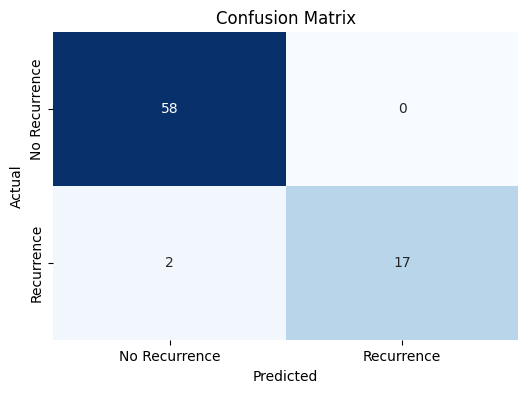

In [21]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['No Recurrence', 'Recurrence'],
            yticklabels=['No Recurrence', 'Recurrence'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## 5.2 Feature Importance

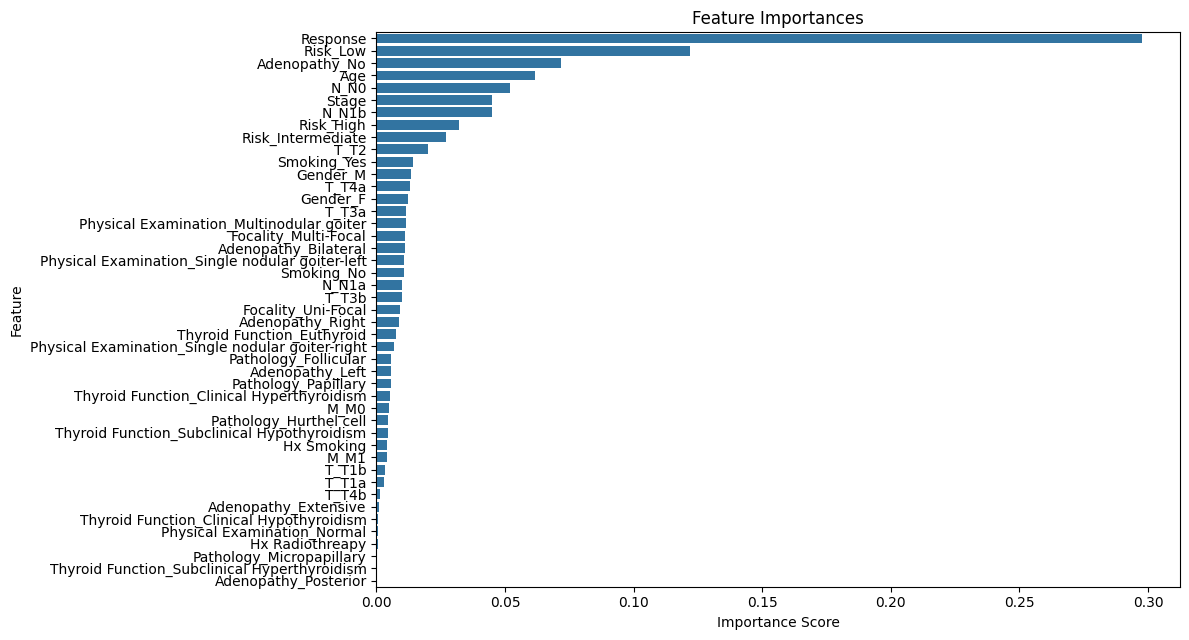

In [22]:
feature_importances = grid_search.best_estimator_.named_steps['classifier'].feature_importances_


importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
importance_df = importance_df.drop(importance_df[importance_df["Importance"] <= 0].index)
importance_df = importance_df.sort_values(by='Importance', ascending=False).reset_index(drop=True)

plt.figure(figsize=(12, 2+len(importance_df)*0.1)) 
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importances')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

## 5.3 ROC curve

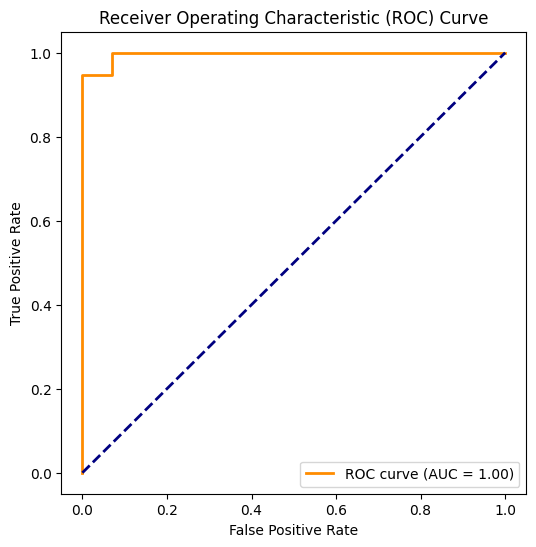

In [23]:
from sklearn.metrics import roc_curve, auc

y_pred_proba = grid_search.predict_proba(X_test)[:, 1]

# Compute
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

## 5.4 Precision-Recall Curve

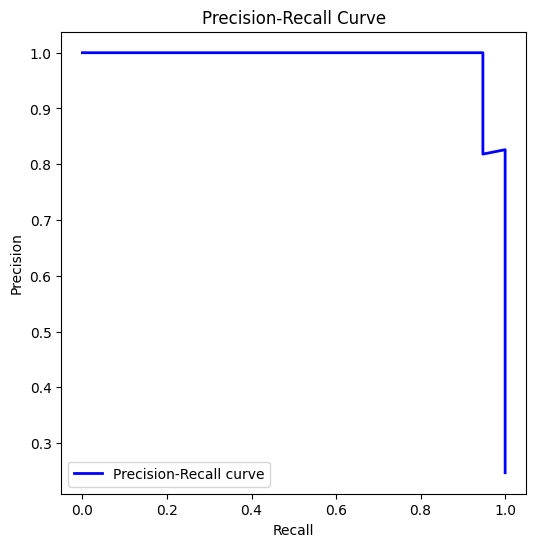

In [24]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)

plt.figure(figsize=(6, 6))
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()

## 5.5 Forest Visualization

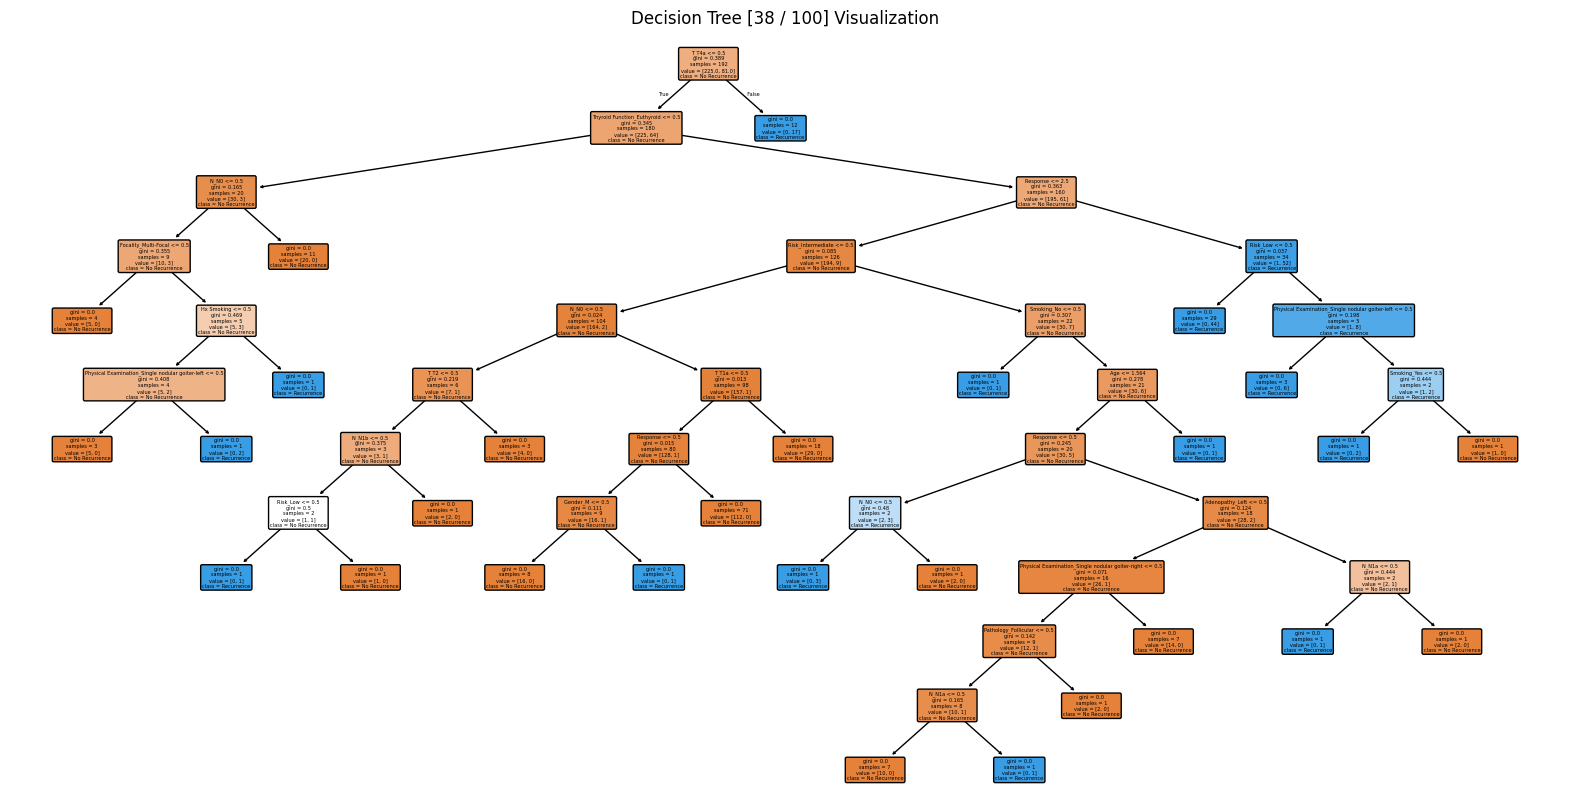

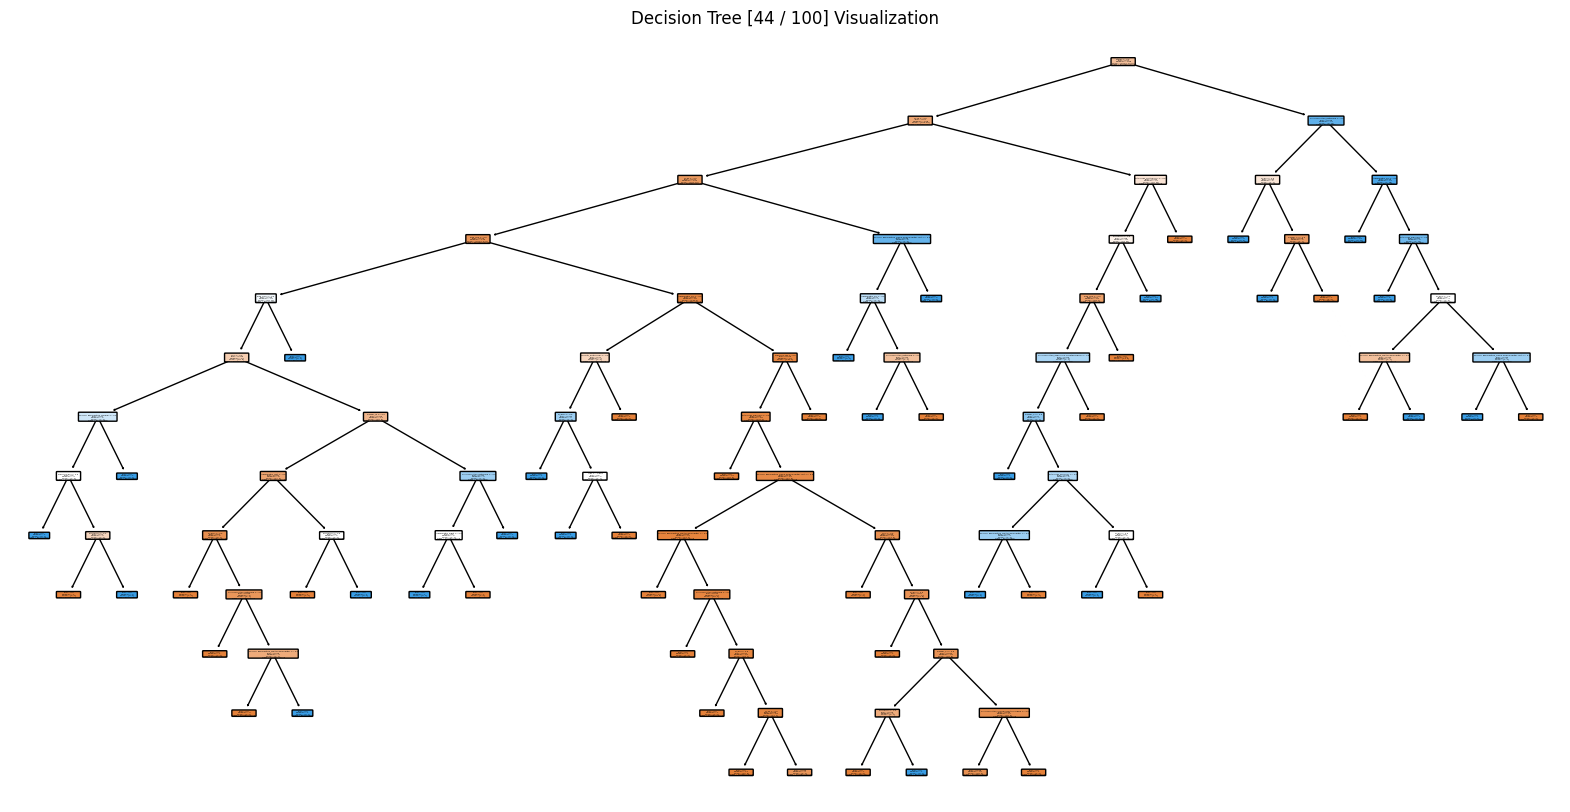

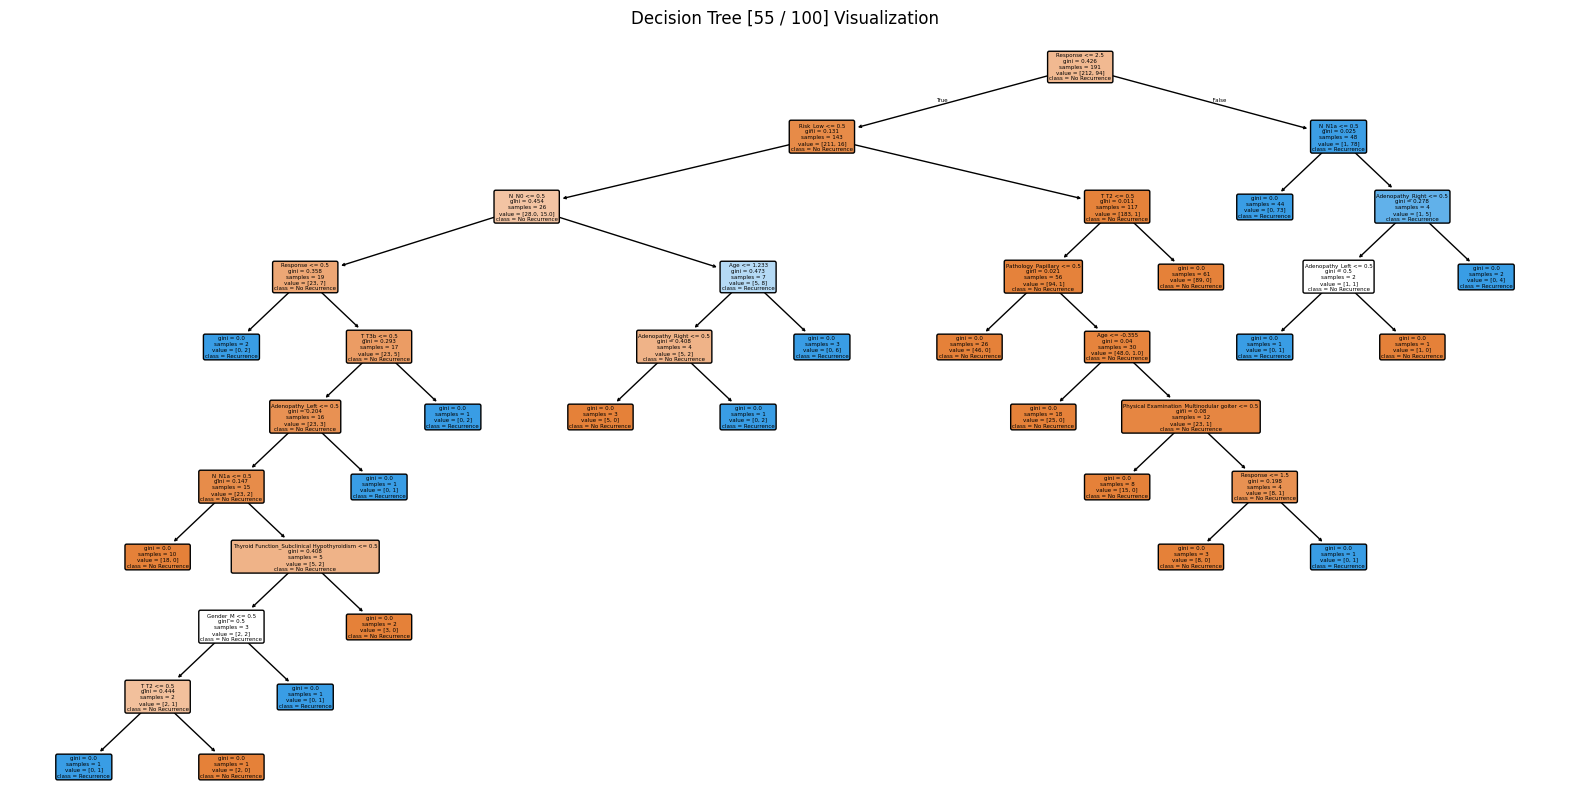

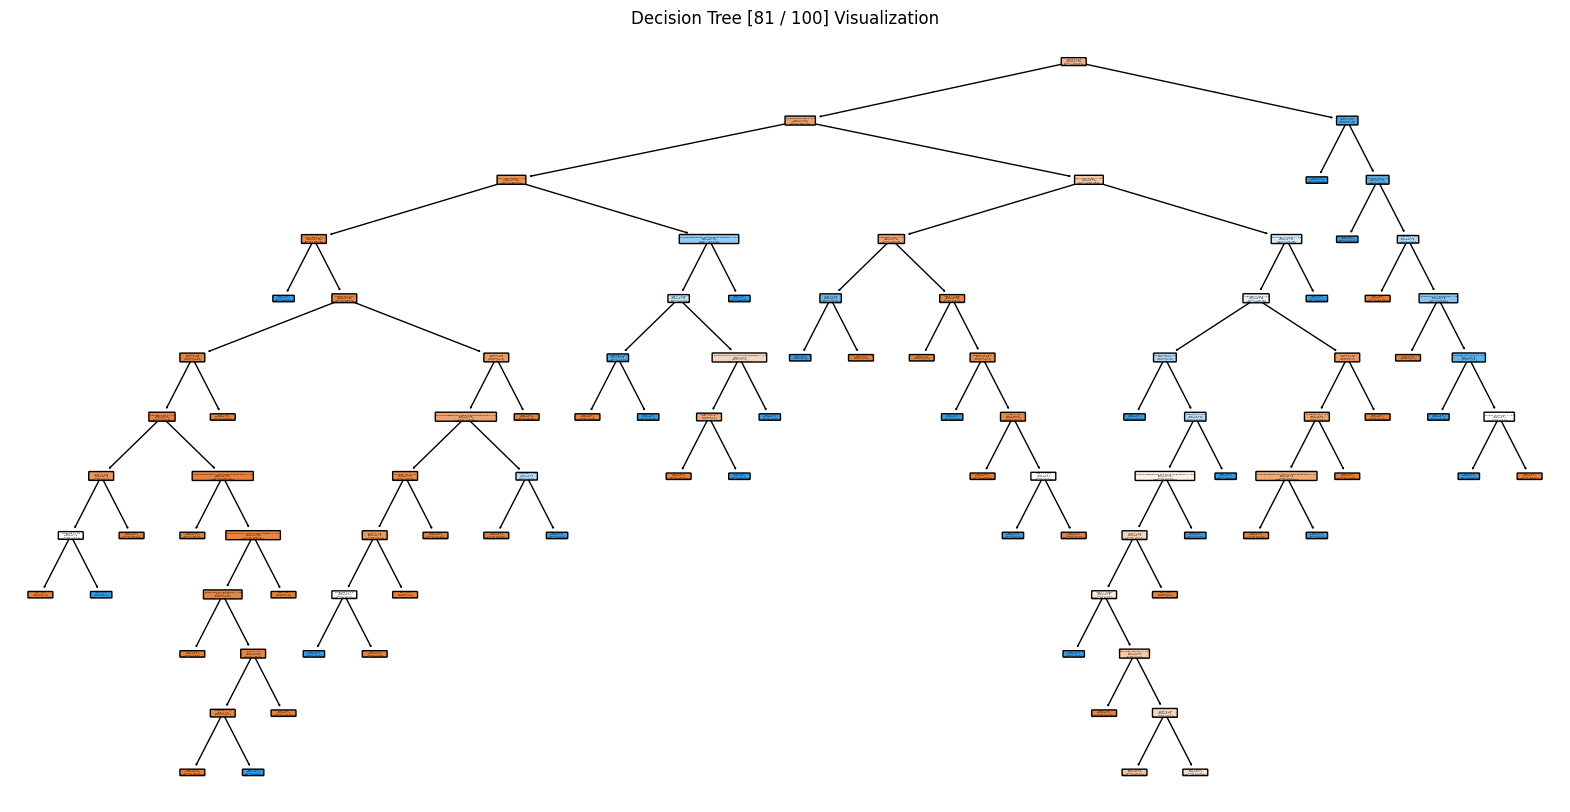

In [25]:
from sklearn.tree import plot_tree
import numpy as np


TREE_COUNT_TO_PLOT = 4

best_classifier = grid_search.best_estimator_.named_steps["classifier"]

selected_trees_idxs = np.random.choice(
    range(len(best_classifier)),
    size=TREE_COUNT_TO_PLOT,
    replace=False,
)

selected_trees_idxs.sort()

for i in selected_trees_idxs:
    tree = best_classifier[i]
    plt.figure(figsize=(20, 10))
    plot_tree(
        tree,
        filled=True,
        feature_names=X.columns,
        class_names=["No Recurrence", "Recurrence"],
        rounded=True,
    )
    plt.title(f"Decision Tree [{i+1} / {len(best_classifier)}] Visualization")
    plt.show()

## 5.6 Distribution of Predicted Probabilities

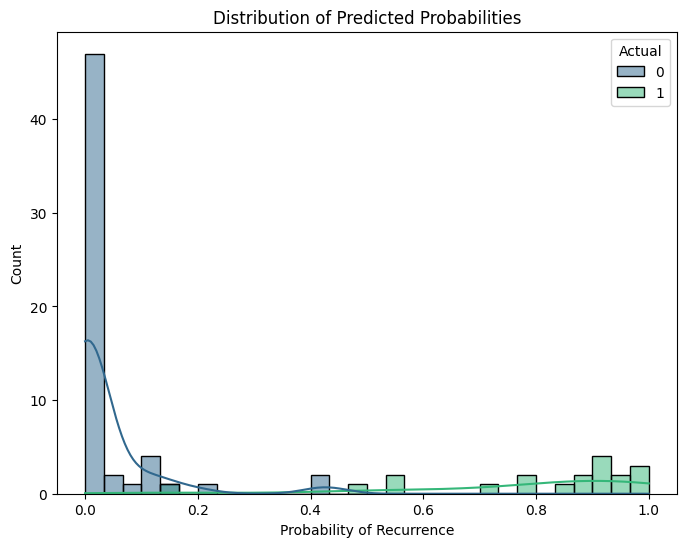

In [26]:
prob_df = pd.DataFrame({'Probability of Recurrence': y_pred_proba, 'Actual': y_test.to_numpy().flatten()})

plt.figure(figsize=(8, 6))
sns.histplot(data=prob_df, x='Probability of Recurrence', hue='Actual', kde=True, bins=30, palette='viridis')
plt.title('Distribution of Predicted Probabilities')
plt.xlabel('Probability of Recurrence')
plt.ylabel('Count')
plt.show()

## 5.7 Summary

In [27]:
print("Best Parameters:", grid_search.best_params_)
print("Cross-Validation Accuracy:", grid_search.best_score_)
print("Test Set Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Feature Importances:\n", importance_df)

Best Parameters: {'classifier__max_depth': 12, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2}
Cross-Validation Accuracy: 0.9509783183500794
Test Set Accuracy: 0.974025974025974
Classification Report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.98        58
           1       1.00      0.89      0.94        19

    accuracy                           0.97        77
   macro avg       0.98      0.95      0.96        77
weighted avg       0.97      0.97      0.97        77

Feature Importances:
                                              Feature  Importance
0                                           Response    0.297562
1                                           Risk_Low    0.121785
2                                      Adenopathy_No    0.071675
3                                                Age    0.061634
4                                               N_N0    0.051822
5                                   

## **5.8 Compact Summary:**

* Best model hit ***95.1%*** accuracy on Cross-Validation
* Best model hit ***97.4%*** accuracy on Test-Set